In [78]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.models.TTree.Model_TTree_v20
mcsangle:pl.DataFrame
dfana:pl.DataFrame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import uproot.models
import uproot.models.TTree

def get_dump(fname):

    # mcstree:uproot.models.TTree.Model_TTree_v20
    mcstree = uproot.open(fname)

    arr={}
    
    alldata:ak.Array
    alldata = mcstree.arrays()
    top = len(alldata)

    klist = ['run','subrun','event','isContained','len','trkpdg','E','Ereco','fitstatus' ]
    nevts = [len(v) for v in alldata['azx'][:top]]
    for c in klist:
        if c in alldata.fields:
            a  = alldata[c][:top]
            arr[c] = np.repeat(a,nevts)
        
    klist = ['azx','azy','avalid', 'Ei_true', 'ei']
    for c in klist:
        a  = alldata[c][:top]
        arr[c] = ak.ravel(a)
    
    tangles = pd.DataFrame(arr)
    dfret = pl.from_pandas(tangles)
    dfret = dfret.with_columns(
        p = (pl.col("E")**2 - 0.1057**2).sqrt()
    )
    dfret = dfret.with_columns(
        stepei = pl.col('ei'),
        ei = (pl.col('ei').cum_count().over(selection_events()) - 1)*10
    )
    return dfret


mcs = get_dump('../data/muon_only_chi2_llhd.root:t1')

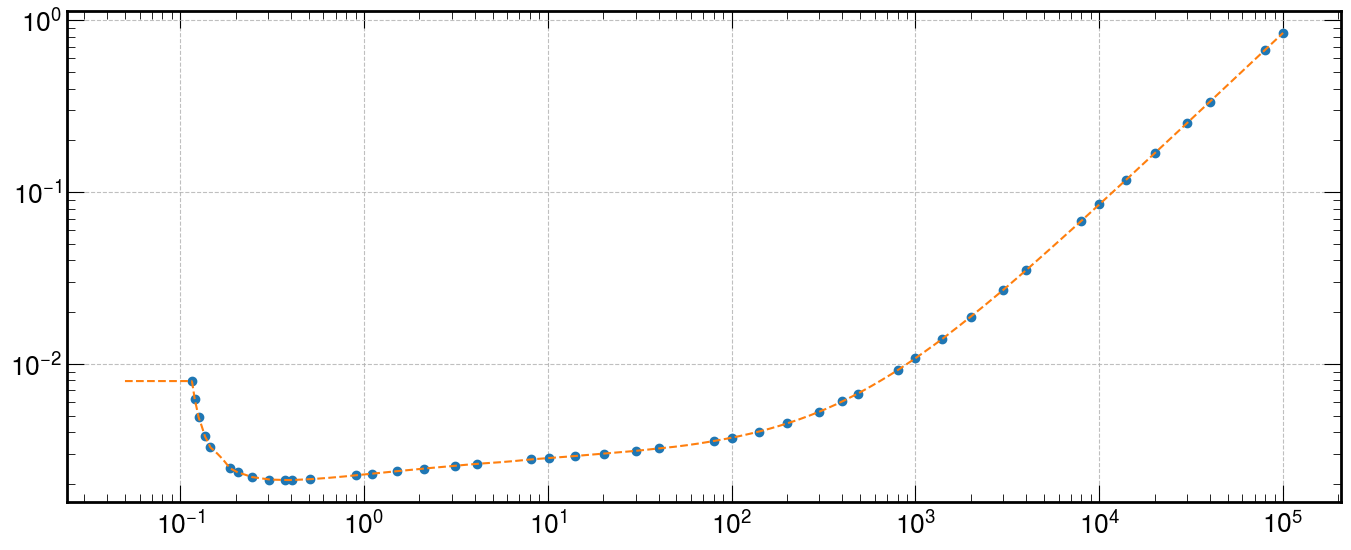

In [79]:
dEdx = np.array([
    5.687, 4.461, 3.502, 2.731, 2.340, 1.771, 1.670, 1.570, 1.519, 1.508,
    1.510, 1.526, 1.610, 1.645, 1.700, 1.761, 1.829, 1.877, 1.991, 2.028,
    2.084, 2.149, 2.232, 2.304, 2.548, 2.663, 2.888, 3.224, 3.774, 4.332,
    4.808, 6.585, 7.730, 10.015, 13.494, 19.288, 25.147, 48.769, 60.675,
    84.472, 120.406, 180.375, 240.642, 482.918, 604.590, 
])*1.396*1e-3
E_GeV = np.array([
    0.115695, 0.119693, 0.125695, 0.135694, 0.145714, 0.185714, 0.205644,
    0.245698, 0.305658, 0.372031, 0.405711, 0.505671, 0.905689, 1.10606,
    1.50571, 2.10565, 3.1058, 4.10536, 8.10569, 10.1106, 14.1104, 20.1103,
    30.1102, 40.1101, 80.1101, 100.1, 140.1, 200.1, 300.1, 400.1, 484.6,
    800.1, 1000.0, 1400.0, 2000.0, 3000.0, 4000.0, 8000.0, 10000.0, 14000.0,
    20000.0, 30000.0, 40000.0, 80000.0, 1e+05
])
from scipy.interpolate import CubicSpline
# dEdx_vs_E = CubicSpline(E_GeV,dEdx)
E_inter = np.logspace(np.log10(0.05),5,2000)
dEdx_vs_E = np.interp(x=E_inter, xp=E_GeV, fp=dEdx)

plt.plot(E_GeV, dEdx, 'o')
plt.plot(E_inter, dEdx_vs_E, '--')
plt.yscale('log')
plt.xscale('log')


In [80]:
import numba as nb
@nb.njit
def compute_eloss(E, ei):
    Eij = []
    Ej = []
    Elost = []
    _dEj=0
    aux=0
    _Elost=0
    for Eref, step in zip(E, ei):
        if step==0:
            if _Elost != 0:
                for _ in range(aux):
                    Elost.append(_Elost)
            _Eij  = Eref
            _dEj = 0
            _Elost = 0
            _Ej = 0
            aux = 1
        else:
            _Eij = _Ej
            aux+=1
        _dEj = np.interp(_Eij, E_GeV, dEdx)*10
        _Elost += _dEj
        _Ej = _Eij - _dEj
        Eij.append(_Eij)
        Ej.append(_Ej)

    for _ in range(aux):
        Elost.append(_Elost)
    return Eij, Ej, Elost


In [81]:
pl.Config().set_tbl_rows(20)
pl.Config().set_tbl_cols(20)
def create_a_loss(df:pl.DataFrame):
    mcsret = df.sort(selection_events('ei'))
    tmp = mcsret.select(selection_events(['E', 'ei' ]))
    arrtmp = tmp.to_dict()
    arr = {}
    for k in arrtmp.keys():
        arr[k] = arrtmp[k].to_numpy()
    Eij, Ej, Elost = compute_eloss(arr['E'], arr['ei'])
    arr['Ei'] = np.array(Eij)
    arr['Elost'] = np.array(Elost)
    tmppd = pd.DataFrame(arr)
    plEi = pl.from_pandas(tmppd)
    plEi = plEi.select(selection_events(['ei', 'Ei', 'Elost' ]))
    mcsret = mcsret.join(plEi, on=selection_events('ei'), how='inner')
    return mcsret
mcsangle = create_a_loss(mcs)

In [82]:
tmpcount = mcsangle.sort(
    selection_events('ei')
).group_by(selection_events()).agg(
    pl.len(),
)
tmp = mcsangle.join(tmpcount, on=selection_events())
tmp.filter(
    pl.col("Ei")<0.1057
).group_by(selection_events()).agg(
    total = pl.col('len').first(),
    minors=pl.len(),
    E=pl.col('E').first()
).with_columns(
    frac = pl.col('minors')/pl.col('total')
)


run,subrun,event,total,minors,E,frac
i32,i32,i32,f64,u32,f64,f64
1,443,72,718.035965,4,1.598083,0.005571
1,282,83,781.708113,2,1.822588,0.002558
1,503,57,1250.348731,5,2.902222,0.003999
1,401,70,911.833379,2,2.111829,0.002193
1,410,34,1014.916177,1,2.40625,0.000985
1,504,26,1067.292305,2,2.491107,0.001874
1,433,9,1055.51635,1,2.50956,0.000947
1,81,68,631.774186,1,1.478292,0.001583
1,90,93,1296.461165,2,3.074772,0.001543


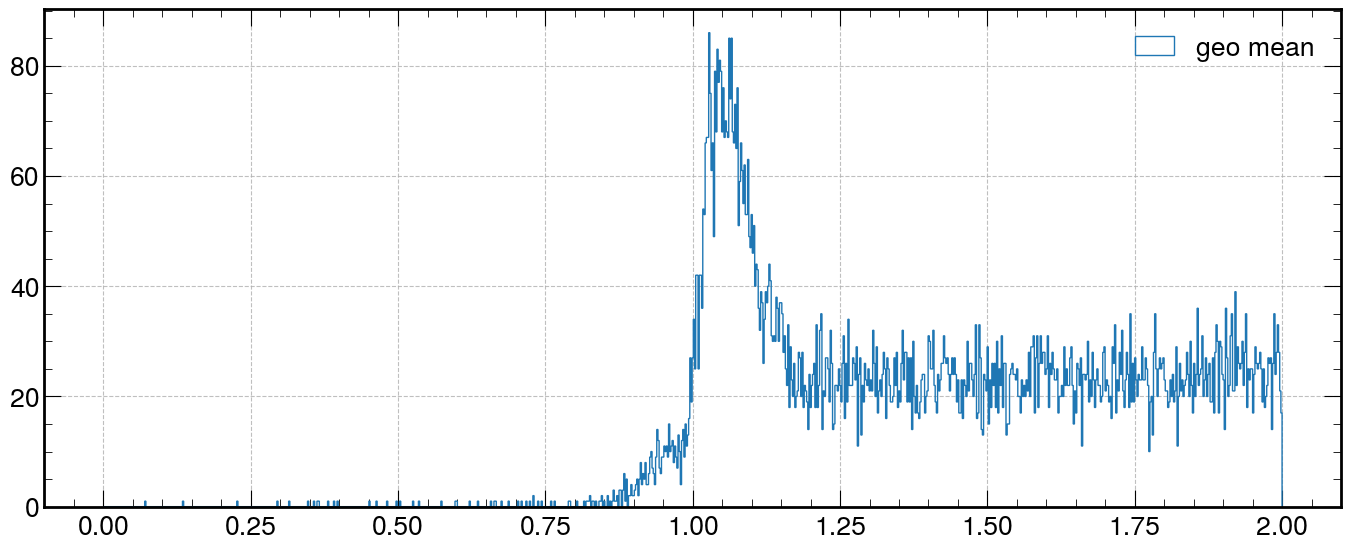

In [83]:
dftmp = mcsangle.sort(selection_events('ei')).group_by(selection_events()).agg(
    pl.col("isContained").last(),
    E = pl.col("E").last()-0.1057,
    Elost = pl.col("Elost").last(),# - pl.col('Ei').last(),
    nsteps = pl.col('ei').len(),
    ei = pl.col('ei').first(),
).with_columns(
    diff = ((pl.col("E"))/pl.col('Elost')),
# ).filter(pl.col("isContained")
# ).filter(
#     pl.col('ei') < 30
)
plt.hist(dftmp['diff'], bins=np.linspace(0.,2,1000), histtype='step', label='geo mean');
plt.legend()
# plt.xscale('log')
mcsangle = mcsangle.join(dftmp.select(selection_events(['diff','nsteps'])), on=selection_events())

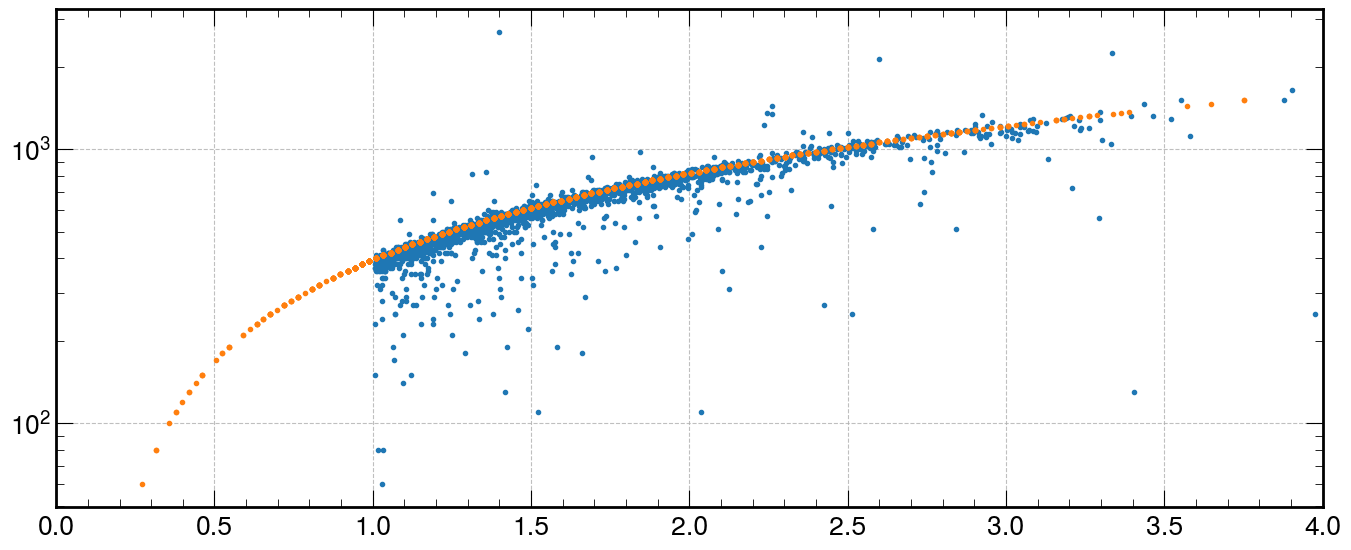

In [84]:
len_cm = np.array([9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
          3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
          2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
          1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])/1.396
 
KE_GeV = np.array([10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
          4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
          200000, 300000, 400000])/1e3
from scipy.interpolate import CubicSpline
KE_by_len = CubicSpline(len_cm,KE_GeV)
tmp = mcsangle.group_by(selection_events()).agg(
    pl.col('E').first(),
    pl.col('isContained').first(),
    pl.len()*10,
).filter(pl.col('isContained')).with_columns(
    Erange = pl.col('len').map_elements(lambda x: KE_by_len(x), return_dtype=pl.Float32) + 0.1057
)
plt.plot(tmp['E'],tmp['len'],'.')
plt.plot(tmp['Erange'],tmp['len'],'.')
plt.xlim(0,4)
# plt.xscale('log')
plt.yscale('log')

/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/tmp/ipykernel_4042174/4057648201.py:52: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))


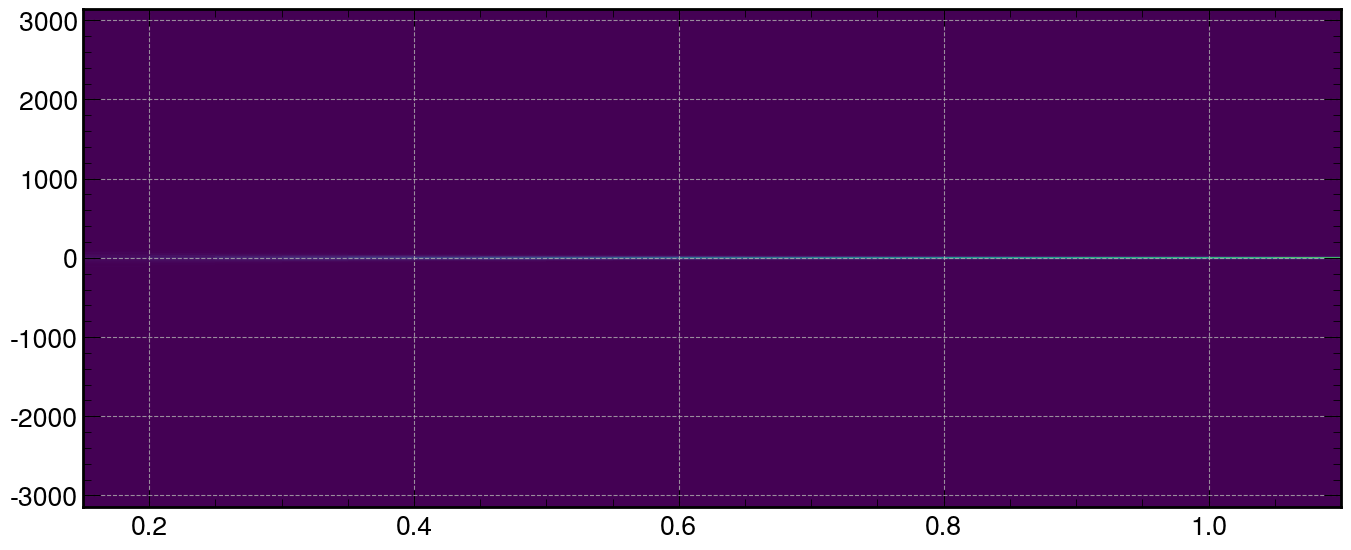

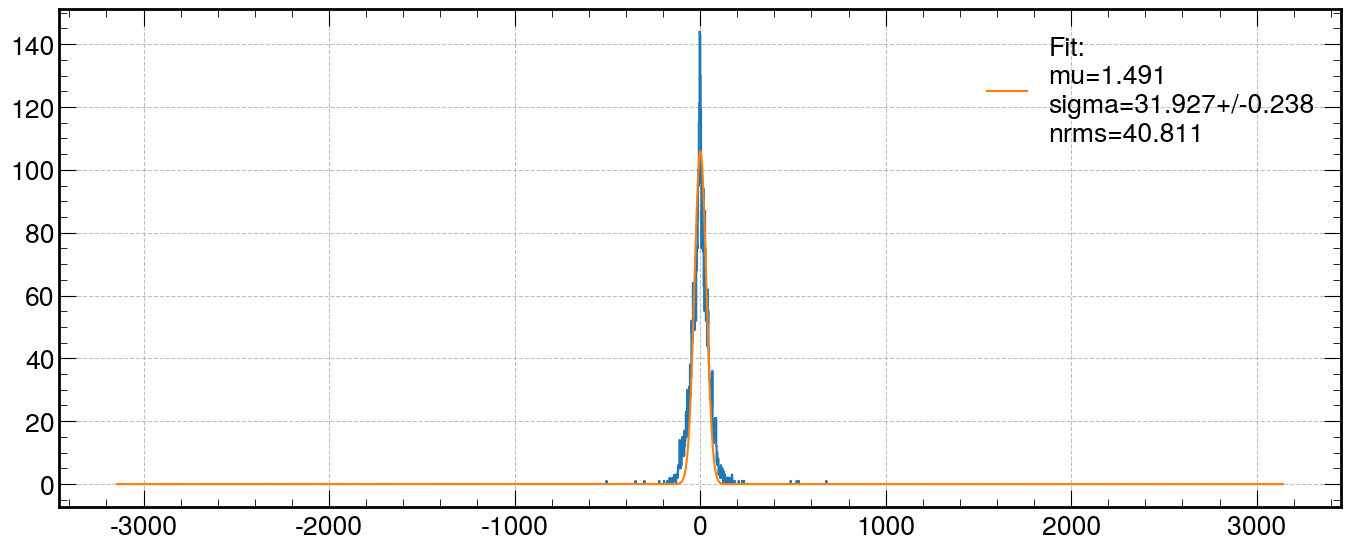

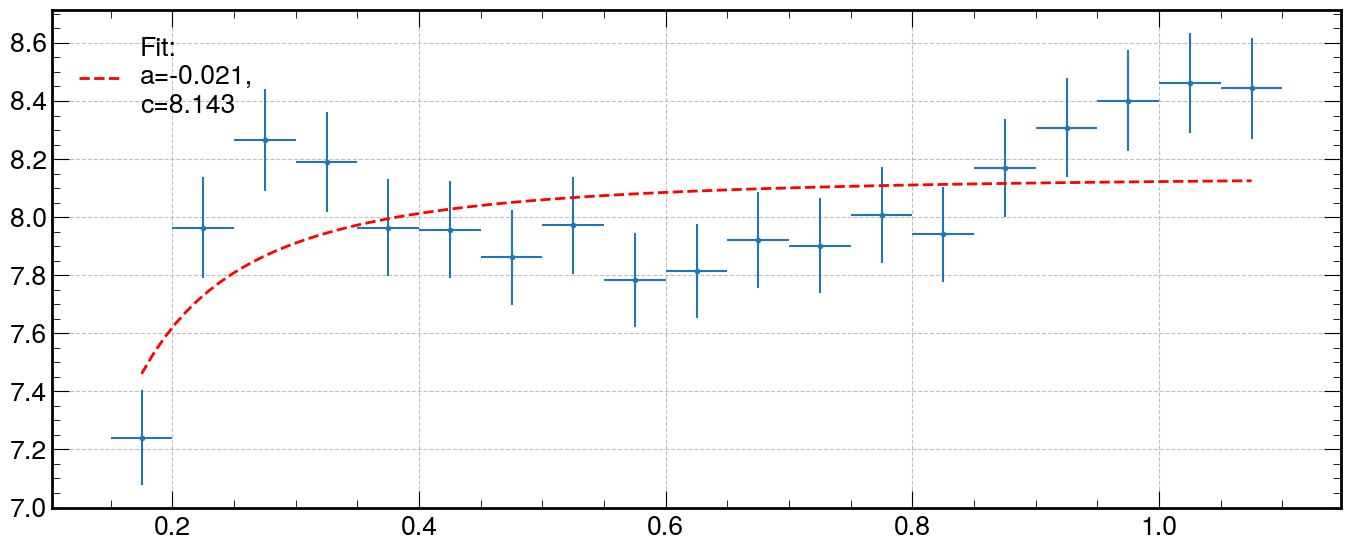

In [58]:
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

def fit_s2(x, a, c):
    return (a/x**2+c)

def compute_s2(p, rms):
    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    beta = np.sqrt(1 - ((m_muon*m_muon)/(p*p + m_muon*m_muon)))
    const =  (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return p*beta*rms/const

def compute_s2_err(p, rms, erp_percent, errms):
    s2 = compute_s2(p, rms)
    return s2*np.sqrt(erp_percent**2 + errms**2/rms**2)

    

def cut_rms(data:np.ndarray, cut=2.7, repeat=5) -> float:
    rms = 0
    for _ in range(repeat):
        rms = np.std(data)
        data = data[abs(data) < cut*rms]
    rms = np.std(data)
    return rms

variable='Ei'

dfc = mcsangle.filter(
    pl.col('ei') != -1,
    # pl.col('nsteps') > 2,
    pl.col('avalid'),
    pl.col('len')>30,
)
# binsx = np.logspace(np.log10(0.15),np.log10(1.5),50)
binsx = np.linspace(0.15,1.1,20)
rms, _, _ = binned_statistic(np.sqrt(dfc[variable]**2-0.1057**2), dfc['azx'], cut_rms, binsx)
count, _, _ = binned_statistic(np.sqrt(dfc[variable]**2-0.1057**2), dfc['azx'], "count", binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
hh, hxe, hye, _ = plt.hist2d(np.sqrt(dfc[variable]**2-0.1057**2), dfc['azx'], bins=[binsx, np.linspace(-3141.5,3141.5,3141)] );


aux = 0
plt.figure()
hycenters = (hye[:-1] + hye[1:])*0.5
plt.step(hycenters, hh[aux])
popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))
perr = np.sqrt(np.diag(pcov))
plt.plot(hycenters, gaus(hycenters, *popt), label = f"Fit:\nmu={popt[0]:5.3f}\nsigma={popt[1]:5.3f}+/-{perr[1]:5.3f}\nnrms={rms[aux]:5.3f}")
plt.legend()


plt.figure()
nanrms = rms[~np.isnan(rms)]
errms = nanrms/np.sqrt(2*(count[~np.isnan(rms)]-1))
nancenters = bins_center[~np.isnan(rms)]
nancount = count[~np.isnan(rms)]
ercenter = np.zeros_like(nancenters)
ercenter = (binsx[1:] - binsx[:-1])*0.5

# nancenters = (hxe[:-1] + hxe[1:])*0.5
# ercenter = (binsx[1:] - binsx[:-1])*0.5
# nanrms = []
# nancount = []
# errms = []
# for v, c in zip(hh, count):
#     popt, pcov = curve_fit(gaus,hycenters, v,p0=[0,20,20], sigma=1/np.sqrt(v))
#     nanrms.append(abs(popt[1]))
#     perr = np.sqrt(np.diag(pcov))
#     _errms = np.sqrt(perr[1]**2 + popt[1]**2/(2*c-2))
#     errms.append(_errms)
    
s2 = compute_s2(nancenters, nanrms)
errS2 = compute_s2_err(nancenters, rms, 0.02, errms)
plt.errorbar(nancenters, s2, errS2, ercenter, '.' )
popt, pcov = curve_fit(fit_s2, nancenters, s2, p0=[0.1, 11], sigma=errS2)#np.ones_like(s2))
# plt.plot(nancenters, func(nanrms, *[0.1,11]), 'r--', label="Fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
# nancenterfit = np.logspace(np.log10(nancenters[0]), np.log10(nancenters[-1]),100)
nancenterfit = np.linspace(nancenters[0], nancenters[-1],100)
plt.plot(nancenterfit, fit_s2(nancenterfit, *popt), 'r--', label="Fit:\n" r"a=%5.3f," "\n" r"c=%5.3f" % tuple(popt), lw=2)
plt.legend()
# plt.xscale('log')


# p_s2 = nancenters
# plt.plot(nancenterfit, np.interp(nancenterfit, p_s2, s2))





8.781419041499793

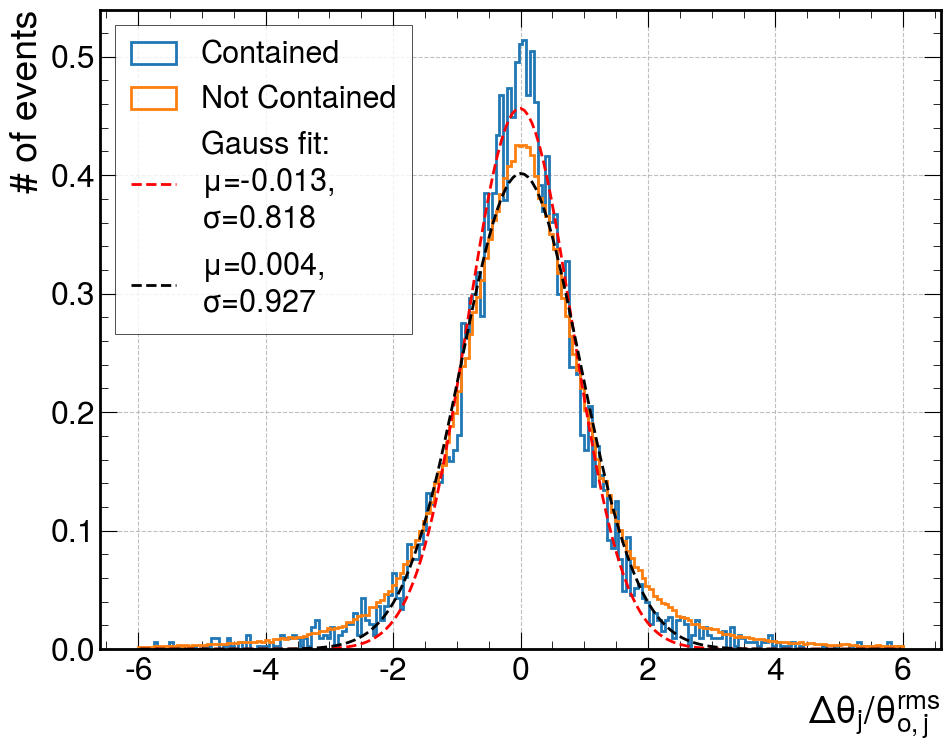

In [128]:
def compute_rms(p=None, _ei=None):
    if p is None: 
        p = pl.col('p')
    if _ei is None: 
        # _ei = pl.col('ei'root)
        _ei = pl.col('Ei')
    
    a = 0.079
    c = 10.435

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Eij = _ei

    nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
    beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
    tH0 = ( (a/nonrel_pij**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return tH0

mcsangle = mcsangle.with_columns(
    rms = ( compute_rms()**2 + 0**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
)

df = mcsangle
dfplot = df#.filter(pl.col("E")<1)#.filter((pl.col('azx')/pl.col('rms')).abs()>0.0007)

def create_dfplot(df, iscontained=True):
    
    dfplot = df.filter(
        pl.col("isContained") == iscontained
    ).filter(
        pl.col('avalid')== True
    ).filter(
        pl.col('trkpdg').abs() == 13
    )

    dfplotnotend = dfplot.group_by(selection_events()).agg(
        pl.col('ei').head(pl.col('ei').len()),
        pl.col('E').first(),
        # pl.col('ei').tail(5)
    ).filter(
        pl.col('ei').len()>0,
        pl.col('E').is_between(3,4)
    ).explode('ei')
    dfplot = dfplot.join(dfplotnotend, on=selection_events('ei'))
    return dfplot
dfplot = create_dfplot(df, False)
dfplotc = create_dfplot(df, True)

plt.figure(figsize=(10,8))
binsx = np.linspace(-6,6,200)
# heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms'])*np.sqrt(2), bins=binsx, histtype='step', label=r'$\sqrt{2} \times \Delta\theta_{xz}/\theta^{rms}_o$',lw=2,color='k');
heigthsc, hedgesc, _ = plt.hist((dfplotc['azx']/dfplotc['rms']), bins=binsx, histtype='step', label=r'Contained',lw=2, density=True);
heigths, hedges, _ = plt.hist((dfplot['azx']/dfplot['rms']), bins=binsx, histtype='step', label=r'Not Contained',lw=2, density=True);
hcenters = (hedges[1:] + hedges[:-1])*0.5
# cfitlim = abs(hcenters)<1.5
# hcenters = hcenters[cfitlim]
# heigths = heigths[cfitlim]
poptc, pcovc = curve_fit(gaus, hcenters, heigthsc, p0=[0,1,35000])#, sigma=1/np.sqrt(heigths))
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,35000])#, sigma=1/np.sqrt(heigths))
perr = np.sqrt(np.diag(pcov))
perrc = np.sqrt(np.diag(pcovc))
# popt[1] = popt[1]/np.sqrt(2)
plt.plot(hcenters, gaus(hcenters, *poptc), 'r--', label="Gauss fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f" % tuple(poptc[:2]), lw=2)
plt.plot(hcenters, gaus(hcenters, *popt), 'k--', label=r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f" % tuple(popt[:2]), lw=2)
plt.tick_params(labelsize=23)
plt.xlabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.ylabel('# of events', fontsize=27)
# plt.yscale('log')
legend = plt.legend(frameon=True, fontsize=22, fancybox=False, loc='upper left')
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_linewidth(0.6)
(dfplotc['azx']/dfplotc['rms']).drop_nans().std()


In [107]:
df.filter(pl.col('isContained')).group_by(selection_events()).agg(
    pl.all().first()
).sort('E', descending=True)

run,subrun,event,isContained,len,trkpdg,E,Ereco,fitstatus,azx,…,Ei_true,ei,p,stepei,Ei,Elost,diff,nsteps,rms,theta
i32,i32,i32,bool,f64,i32,f64,f64,bool,f64,…,f64,u32,f64,f64,f64,f64,f64,u32,f64,f64
1,616,34,true,332.254797,13,7.461015,0.810843,true,-11.471029,…,0.0,0,7.460266,10.0,7.461015,0.8758,8.398394,32,1.167324,27.031922
1,954,4,true,249.00336,13,6.946584,0.947636,true,-35.817816,…,0.0,0,6.94578,10.0,6.946584,0.625921,10.929309,23,1.253837,36.994657
1,799,68,true,332.810749,13,6.474301,0.800497,true,2.129356,…,0.0,0,6.473438,10.0,6.474301,0.863316,7.376906,32,1.345382,2.284147
1,976,71,true,115.112798,13,4.744409,4.271353,true,1.807226,…,0.0,0,4.743231,10.0,4.744409,0.264098,17.564321,10,1.836656,2.917428
1,15,98,true,338.224791,13,4.737223,4.690412,true,-0.957081,…,0.0,0,4.736043,10.0,4.737223,0.841138,5.506256,32,1.839446,6.067975
1,869,25,true,327.899424,13,4.735038,0.773746,true,-9.029902,…,0.0,0,4.733858,10.0,4.735038,0.815027,5.67998,31,1.840296,15.37236
1,887,25,true,166.717723,13,4.173644,2.874371,true,-4.238775,…,0.0,0,4.172305,10.0,4.173644,0.391854,10.381273,15,2.088346,8.685907
1,899,33,true,135.42693,13,4.123509,1.715023,true,8.502807,…,0.0,0,4.122154,10.0,4.123509,0.313419,12.819296,12,2.113794,16.612874
1,595,11,true,263.360786,13,3.976202,1.056972,true,8.544051,…,0.0,0,3.974797,10.0,3.976202,0.647683,5.975921,25,2.192291,8.559585


In [12]:
mcsangle.sort(
    selection_events('ei')
).select(selection_events(['isContained', 'theta','azx','azy','rms', 'avalid','E','Ei','ei'])).with_columns(
    deltatheta_over_rms = pl.col('azx')/pl.col('rms')
).filter(
    pl.col('isContained')==False
).filter(
    pl.col('deltatheta_over_rms').abs()>4
).head(100).tail(80)

run,subrun,event,isContained,theta,azx,azy,rms,avalid,E,Ei,ei,deltatheta_over_rms
i32,i32,i32,bool,f64,f64,f64,f64,bool,f64,f64,u32,f64
1,0,14,false,11.380793,-11.182635,-2.114504,0.913086,true,9.649895,9.53717,40,-12.247074
1,0,14,false,7.382291,6.093153,-4.167938,0.918513,true,9.649895,9.480851,60,6.633718
1,0,14,false,9.300863,6.122068,-7.001881,0.935168,true,9.649895,9.312068,120,6.54649
1,0,14,false,14.284229,-8.617668,11.391882,0.940849,true,9.649895,9.255865,140,-9.159458
1,0,14,false,9.114348,8.322497,-3.715829,0.949496,true,9.649895,9.171614,170,8.765177
1,0,14,false,7.304154,-6.55534,3.221519,0.955345,true,9.649895,9.115484,190,-6.861751
1,0,15,false,14.299847,6.687122,12.639937,1.183401,true,7.359723,7.359723,0,5.650764
1,0,15,false,29.585541,19.207262,22.503007,1.215167,false,7.359723,7.167469,70,15.806271
1,0,15,false,32.679566,-25.684762,-20.205125,1.219837,false,7.359723,7.140048,80,-21.055888


In [13]:
# Example bad reconstruction, 70,1 is a muons escaping, llhd and range give same result
dfsmalls = dfplot.group_by(selection_events()).agg(
    azx_total = pl.len(),
    azx_small = pl.col('azx').filter((pl.col('azx')/pl.col('rms')).abs()<0.07).count(),
    len = pl.col('len') .first(),
    E = pl.col('E').first()
).with_columns(
    frac = pl.col('azx_small')/pl.col('azx_total')
).filter(pl.col("azx_small")>0)
# df
dfsmalls.describe()

statistic,run,subrun,event,azx_total,azx_small,len,E,frac
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",59781.0,59781.0,59781.0,59781.0,59781.0,59781.0,59781.0,59781.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.0,503.307071,50.467439,52.359947,3.04555,543.393453,5.358131,0.067544
"""std""",0.0,290.126252,28.877446,30.124263,2.361142,305.525392,2.545348,0.054598
"""min""",1.0,0.0,1.0,1.0,1.0,20.360368,1.005568,0.007246
"""25%""",1.0,251.0,25.0,29.0,1.0,309.97093,3.162803,0.035714
"""50%""",1.0,505.0,51.0,48.0,2.0,493.867911,5.247005,0.055556
"""75%""",1.0,756.0,75.0,71.0,4.0,730.387628,7.53222,0.083333
"""max""",1.0,999.0,100.0,174.0,36.0,2832.51291,10.000231,1.0


/home/henrique/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/henrique/.local/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/henrique/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 1, '# of events')

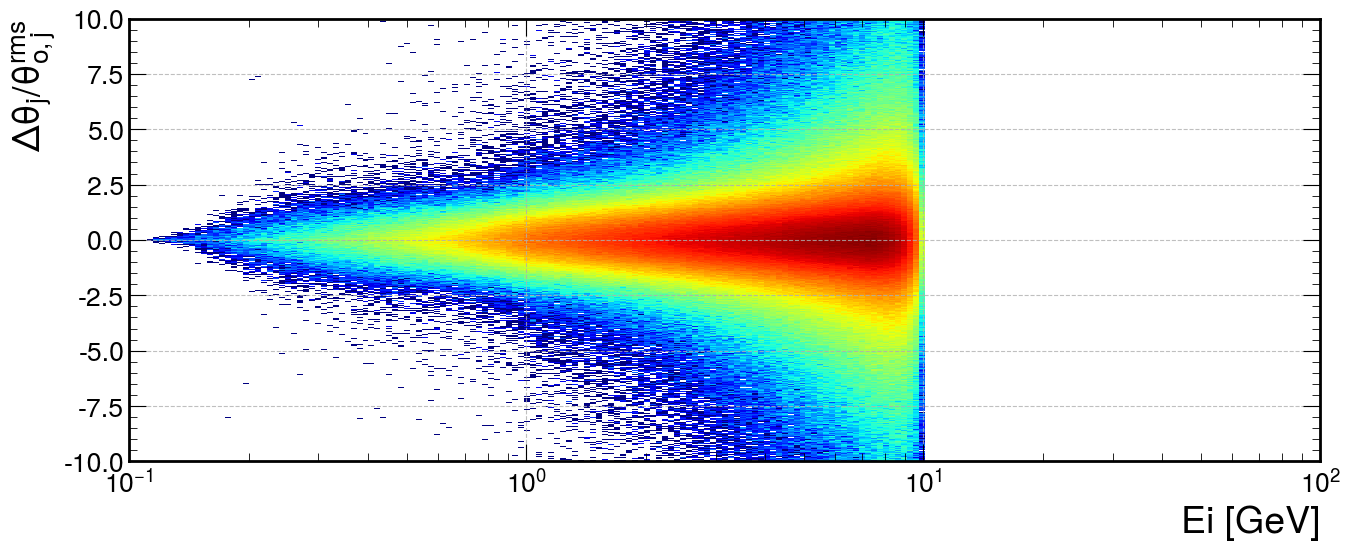

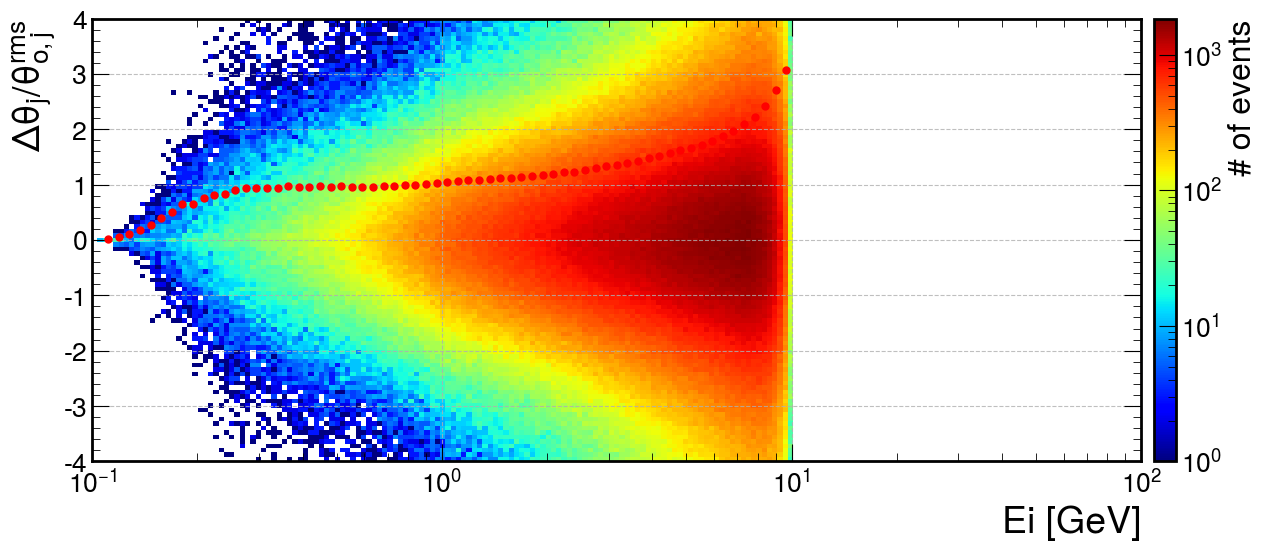

In [14]:

def cut_rms(data:np.ndarray, cut=2.7, repeat=5) -> float:
    rms = 0
    for _ in range(repeat):
        rms = np.std(data)
        data = data[abs(data) < cut*rms]
    rms = np.std(data)
    return rms

plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-10,10,500)],cmap=plt.cm.jet, norm='log', label='Some');
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.xscale('log')

plt.figure()
binsx = np.logspace(-1,2,100)
val, _, _ = binned_statistic(dfplot['Ei'], dfplot['azx']/0.757/dfplot['rms'], cut_rms, binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
plt.hist2d(dfplot['Ei'], dfplot['azx']/0.757/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-4,4,100)], cmap=plt.cm.jet, norm='log')
lines = plt.plot(bins_center, val, 'o', markersize=5, color='r',)
# plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-10,10,100)], cmap=plt.cm.jet, cmin=1)
# fakeE = np.logspace(-1,2,200)
# fakeEi = np.zeros_like(fakeE)
# fakeRMS = compute_rms(fakeE, fakeEi)
# plt.plot(fakeE,fakeRMS, '--', color='red', lw=2)
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
# plt.ylabel(r'$\Delta\theta_{zx}$', fontsize=27)
plt.xscale('log')
cbar = plt.colorbar(pad=0.01)
cbar.ax.set_ylabel('# of events', fontsize=23)
# dfplot.filter(get_event(70,1))
# anatree.nu.filter(get_event(70,1))["RecoLepEnNumu_mcs_llhd"]

In [15]:
# pl.Config.oset_tbl_rows(40)

#     pl.count(),# plot_res_vs_energy(dftemp['E'],
#                    dftemp['RecoLepEnNumu_range'],
#                    label=r'CSDA')
#     pl.all(),
# ).explode(pl.all().exclude(selection_events(['count']))).sort('subrun').sort('count', descending=True).head(40)

def getvalues(df:pl.DataFrame):
    dfllhd = df.sort(selection_events('ei')).group_by(selection_events(),maintain_order=True).agg(
        pl.all().exclude('seg','len','p','trkpdg', 'isContained', 'E'),
        len = pl.col('len').first(),
        p = pl.col('p').first(),
        trkpdg = pl.col('trkpdg').first(),
        E = pl.col('E').first(),
        isContained = pl.col('isContained').first(),
        nvalids = pl.col('avalid').filter(pl.col('avalid')==True).len(),
    ).filter(
        pl.col('nvalids') > 0
    ).filter(
        pl.col('trkpdg').abs() == 13
    ).sort(selection_events())
    vals = dfllhd.select(['theta', 'ei', 'p', 'subrun', 'event', 'azx', 'azy','len', 'avalid', 'run', 'isContained']).to_numpy(structured=True)
    return vals
vals = getvalues(mcsangle)

In [16]:
import numba as nb
@nb.njit
def llhd(evDT, evValid, correct, p, res):
    def S2(p):
        # a = 0.1049
        # c = 11.0038
        a = 0.079
        c = 10.435
        return a/p**2 + c
        # return np.interp(p, p_s2,s2)

    rad_length = 14.0
    stepsize = 10
    m_muon = 0.1057
    Etot = np.sqrt(p*p + m_muon*m_muon)

    result = 0
    dei = 0
    penality = False
    Eij = Etot
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        Eij = Eij - dei
        if Eij>= E_GeV[0]:
            dei = np.interp(Eij, E_GeV, dEdx)*stepsize
        else:
            dei = dEdx[0]*stepsize
        if Eij <= m_muon:
            penality=True
            Eij = m_muon+0.01
        # if nonrel_Eij < m_muon:
        #     return 99999

        red_length = stepsize / rad_length
        pij = np.sqrt(Eij*Eij - m_muon*m_muon)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(pij*pij + m_muon*m_muon)))
        tH0 = ( S2(pij) / (pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
        if correct:
            tH0 *= np.sqrt(2)
        rms_square = (tH0**2 + res**2)
        if evValid[idx] is False:
            continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms_square) - 0.5*dth*dth/rms_square
        if penality:
            prob -= 2*rms_square
        result-=2*prob
    return result
def call_llhd(p:float, res:float, ev:int):
    global DT
    global Valid
    global correct
    
    ev = int(ev)
    result = 0
    result = llhd(DT[ev], Valid[ev], correct, p, res)
    return result


idx: 0, run: 6171714,  subrun: 1, event: 3810, p = 0.27, contained = True


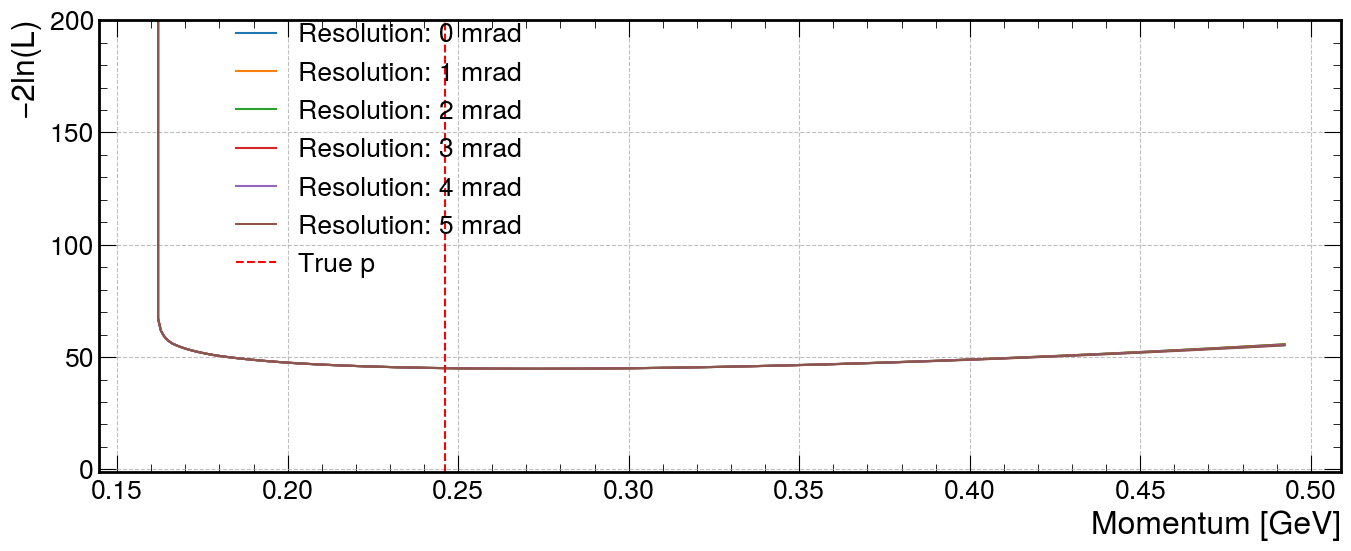

In [17]:
res_scan = [ r for r in range(0,6,1)]
res = [[] for _ in res_scan]
ptry = [[] for _ in res]
idx=0
DT = vals['theta']/0.751#[idx]/np.sqrt(2)
Valid = vals['avalid']
trueP = vals['p']
correct = True
# DT = azy[idx]
for r,i in enumerate(res_scan):
    Erange = KE_by_len(len(DT[idx])*10) + 0.1057
    Prange = np.sqrt(Erange**2 - 0.1057**2)
    for x in np.linspace(Prange*0.8, 2*trueP[idx], 400):
        ll = call_llhd(x, r, idx)
        res[i].append(ll)
        ptry[i].append(x)
    plt.plot(ptry[i], res[i], label=f"Resolution: {r:.0f} mrad")
# plt.yscale('log')
plt.ylim(-1,200)
plt.axvline(trueP[idx], color='r', linestyle='--', label='True p')
plt.ylabel(r'$-2ln(\mathcal{L})$')
plt.xlabel('Momentum [GeV]')
axbox = plt.gca().get_position
plt.legend(loc=(0.1,0.4),ncol=1)
print(f'idx: {idx}, run: {vals["run"][idx]},  subrun: {vals["subrun"][idx]}, event: {vals["event"][idx]}, p = {ptry[0][np.argmin(res[0])]:.2f}, contained = {vals["isContained"][idx]}')

In [18]:
from iminuit import Minuit, cost
from iminuit.util import describe


def lazy_min(start=0, maxevt=None, values = None , resval = 0, fixres = True, docorrect = True, angleadjust = 0.757):
    global trueP
    global DT
    global Valid
    global correct
    global trklen
    
    
    
    DT = values['theta']/angleadjust
    Valid = values['avalid']
    trklen = values['len']
    trueP = values['p']
    correct = docorrect
    
    indexes = [ i for i, _ in enumerate(trueP)]

    if maxevt == None:
        maxevt = len(trueP)
    p_ = trueP[start:maxevt]
    indexes = indexes[start:maxevt]
    
    trueE = np.zeros_like(p_)
    recoE = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pt = p_[idx]
        pars = ['p', 'res', 'ev']
        Erange = KE_by_len(len(DT[idx]+2)*10) + 0.1057
        Prange = np.sqrt(Erange**2 - 0.1057**2)
        m = Minuit(call_llhd, p=2*Prange, res=resval, ev=ev)
        m.tol = 0.01/2.
        m.fixed['ev'] = True
        m.limits['p']=(0.6*Prange,100)
        m.limits['res']=(0,100)
        m.fixed['res'] = fixres
        m.strategy.strategy = 2
        m.migrad()
        vals = [m.values[par] for par in pars]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        recoE[idx] = np.sqrt(vals[0]**2 + 0.1057**2)
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    recoE = recoE.astype(float)
    return trueE, recoE , fitS


In [19]:
maxevt = None
trueE, recoE, fitS = lazy_min(0,maxevt, vals)

100%|██████████| 60941/60941 [00:21<00:00, 2792.79it/s]


In [20]:
trueEc = trueE[vals['isContained'][:maxevt]==True]
recoEc = recoE[vals['isContained'][:maxevt]==True]
fitSc = fitS[vals['isContained'][:maxevt]==True]

trueE = trueE[vals['isContained'][:maxevt]==False]
recoE = recoE[vals['isContained'][:maxevt]==False]
fitS = fitS[vals['isContained'][:maxevt]==False]


In [65]:
def display_en_reco(x,
                    y,
                    actualx = None,
                    binse = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    lmethod='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    figsize=(14,6.7),
                    zscale='log'):
    plt.figure()
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binse,binsy], cmin=1, norm=zscale);
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binse,binsy], cmin=1, norm=zscale);
    fontsize=25
    if makefrac: plt.plot([0,100],[0,100], '--', c='r')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if lmethod:
        legend = plt.legend(frameon=True, title=lmethod, loc='upper right')
    plt.plot();


In [ ]:

display_en_reco(trueE,
                recoE,
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueE,
                recoE,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueEc,
                recoEc,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )


In [25]:
from scipy.stats import binned_statistic
def plot_res_vs_energy(varx, vary, actualx=None, binsx = np.logspace(-1,2,100), fmt = '.:', infotype='std', scalex='log', scaley='linear', **kwargs):
    vary = (vary/varx-1)
    if not actualx is None:
        varx = [v for v in actualx]
    if infotype=='std':
        val, _, _ = binned_statistic(varx, vary*100, manual_std, binsx)
        median, _, _ = binned_statistic(varx, vary, "median", binsx)
        ylabel = r'Energy resolution [%]'
        labelpad=20
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(varx, vary, infotype, binsx)
        ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        labelpad=0
        title = 'Median'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'ms' not in kwargs:
        kwargs['ms'] = 10
    lines = ax.plot(bins_center, val, fmt, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=23, labelpad=labelpad)
    ax.set_xscale(scalex)
    ax.set_yscale(scaley)
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(title=title,fontsize=23)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)


In [ ]:
    
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueEc,
                   recoEc,
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$',
                   )
# plot_res_vs_energy(trueEc
#                    recoEc,
#                    label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,10)
# plt.yscale('log')
# plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

(-1.0, 0.7)

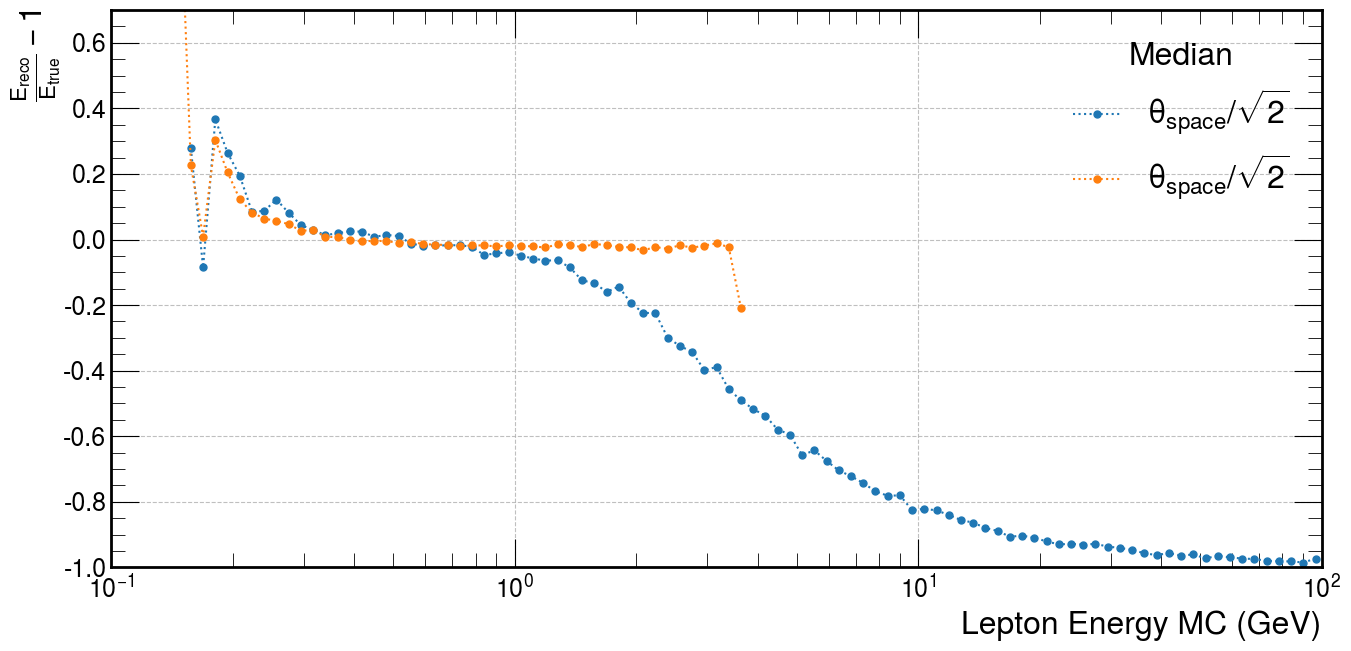

In [26]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueEc,
                   recoEc,
                   infotype='median',
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-1,0.7)
# plt.yscale('log')

Reading nu files... 60/60
Reading geant files... 60/60
Reading reco_tracks files... 60/60

Reading pfp files... 60/60


/tmp/ipykernel_4042174/397136075.py:15: RuntimeWarning: invalid value encountered in divide
  eff = h/htot
/tmp/ipykernel_4042174/397136075.py:16: RuntimeWarning: divide by zero encountered in divide
  ereff = eff*np.sqrt(1/h + 1/htot)
/home/henrique/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


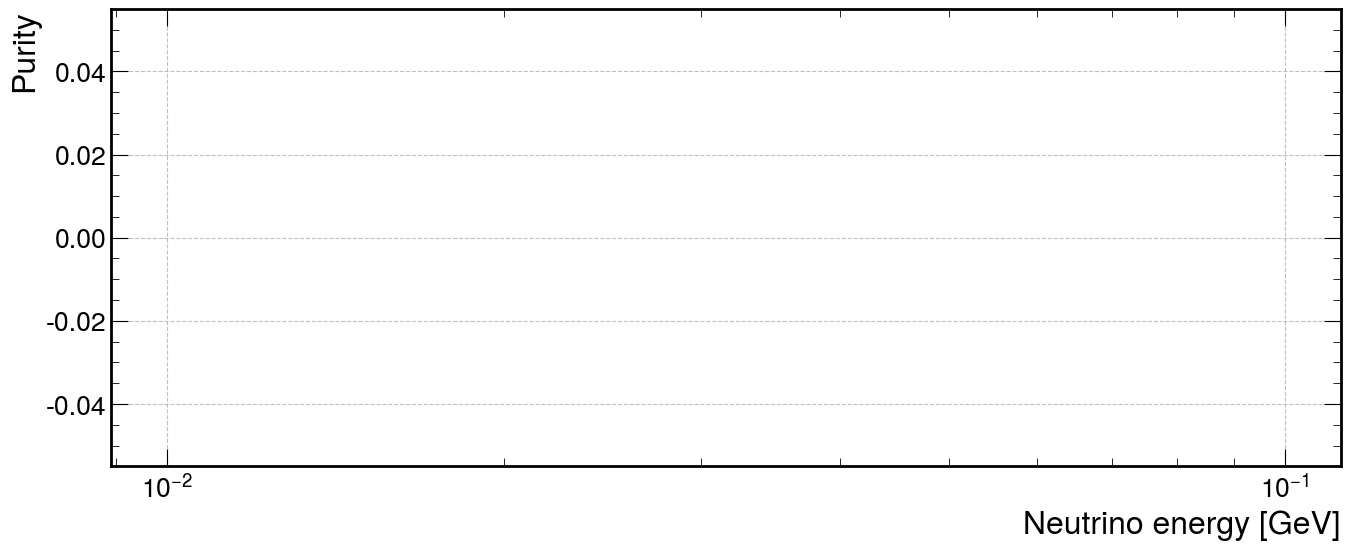

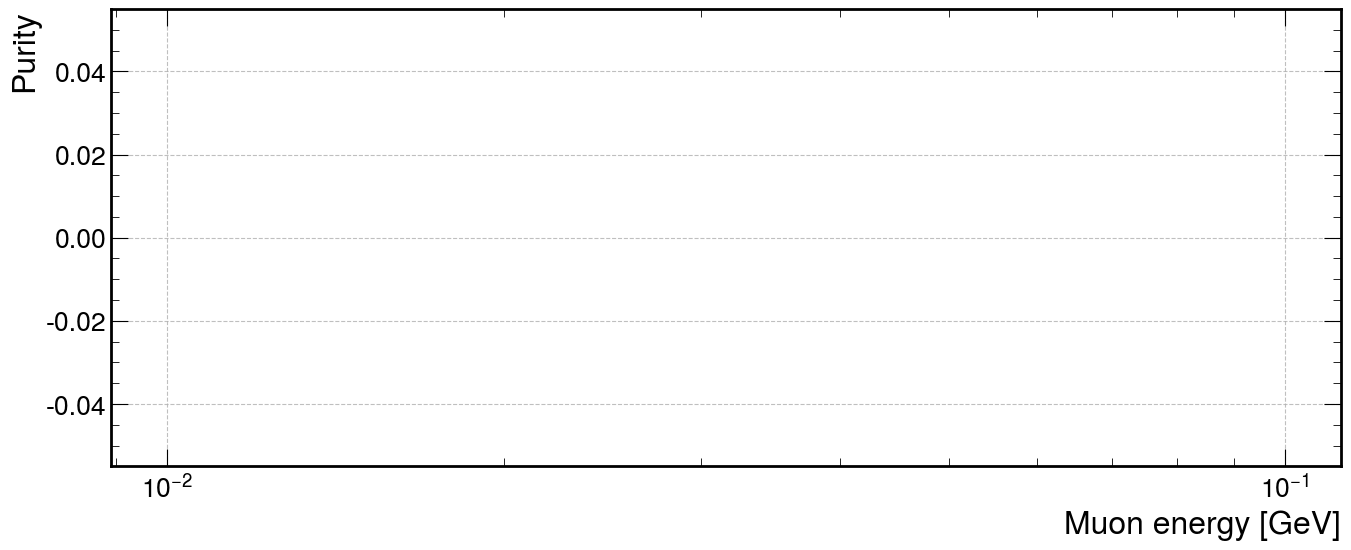

In [90]:
anadf = Anatree("",load_data=False)
anadf.read_parquet(fpath="../data/parquet_anatree_dump_using_reco2/")
dfnu = anadf.nu.collect()
dfnu = dfnu.select(selection_events('enu_truth'))

dfmu = mcsangle.group_by(selection_events()).agg(
    pl.all().first()
)
dfmu = dfmu.join(dfnu, on=selection_events())
dfismu = dfmu.filter(
    pl.col('trkpdg').abs()==13
)

def get_eff(htot,h):
    eff = h/htot
    ereff = eff*np.sqrt(1/h + 1/htot)
    return eff, ereff

def plot_eff(eff, ereff, xlabel):
    x = (binsx[1:]+binsx[:-1])*0.5
    p = plt.stairs(eff, binsx)
    plt.errorbar(x, eff, yerr=ereff, ls='none',marker='none', color=p.get_edgecolor())
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Purity')

binsx = np.logspace(-1,2,50)
hmu, edgemu = np.histogram(dfmu['enu_truth'], bins=binsx)
hismu, edgeismu = np.histogram(dfismu['enu_truth'], bins=binsx)

eff, ereff = get_eff(hmu, hismu)
plot_eff(eff,ereff, "Neutrino energy [GeV]")

plt.figure()
hmu, edgemu = np.histogram(dfmu['E'], bins=binsx)
hismu, edgeismu = np.histogram(dfismu['E'], bins=binsx)

eff, ereff = get_eff(hmu, hismu)
plot_eff(eff,ereff, "Muon energy [GeV]")


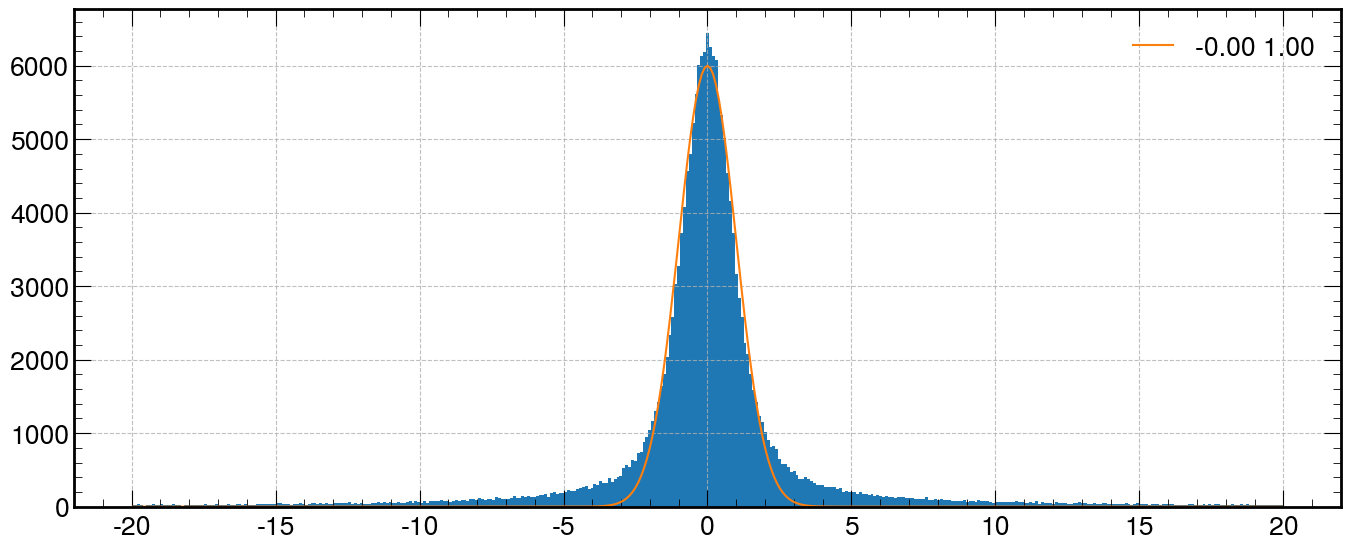

In [855]:
## Checking high energy nu angle resolution

dfhigh = mcsangle.filter(
    # pl.col('p')>5
    pl.col('isContained')==False
).filter(
    pl.col('trkpdg').abs()==13
)

dfhigh = dfhigh.group_by(selection_events()).agg(
    pl.all().head(3)
).explode(
    pl.all().exclude(selection_events())
).filter(
    pl.col('avalid')==True
)

_values = dfhigh['azx']/np.sqrt(dfhigh['rms']**2 + 0**2)
hh, hxe, _ = plt.hist(_values,bins=np.linspace(-20,20,400));
hxc = (hxe[:-1]+hxe[1:])*0.5
popt, pcov = curve_fit(gaus, hxc, hh, p0=[0,0.2,2000])
plt.plot(hxc, gaus(hxc, *popt), label=r"%.2f %.2f" % tuple(popt[:2]))
plt.legend()

# plt.hist(dfhigh['theta'],bins=500);

In [87]:
anatreemuonly = Anatree("", load_data=False)
anatreemuonly.read_parquet('../data/parquet_anatree_muon_only_chi2_llhd_change_chi2/')
nu = anatreemuonly.nu.collect()
# dfres = dfana.group_by(selection_events()).agg(
#     pl.all().first()
# )
def select_numu_cc(df:pl.DataFrame):
    df = df.with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>0).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>0).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
    )
    return df
dfres = select_numu_cc(nu)


Reading nu files... 15/15

Reading reco_tracks files... 15/15

Reading pfp files... 15/15


<Figure size 1400x600 with 0 Axes>

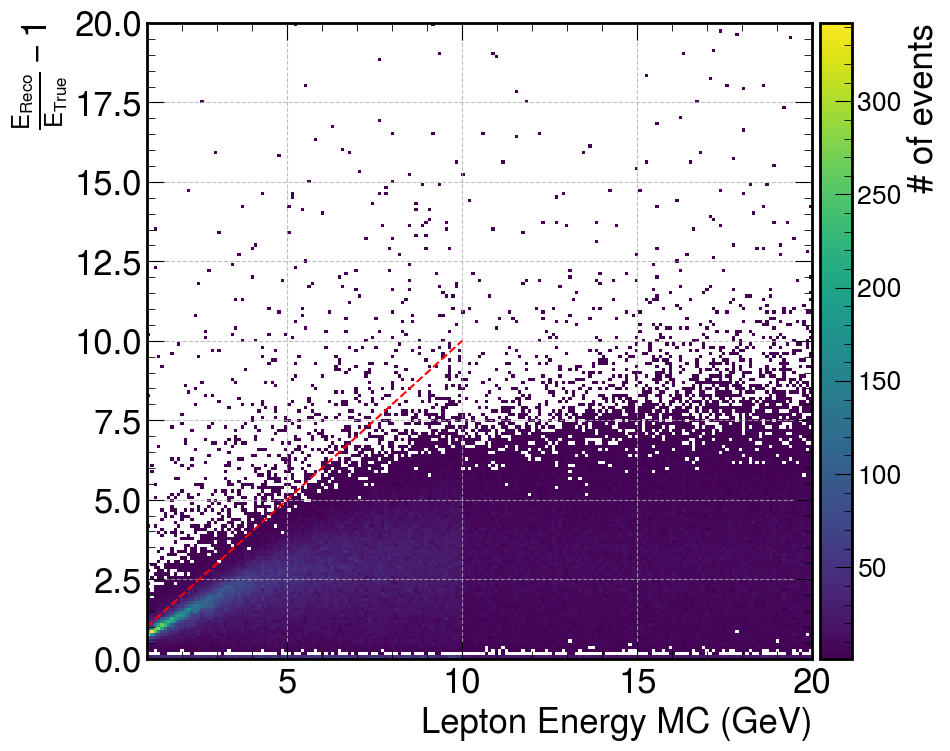

<Figure size 1400x600 with 0 Axes>

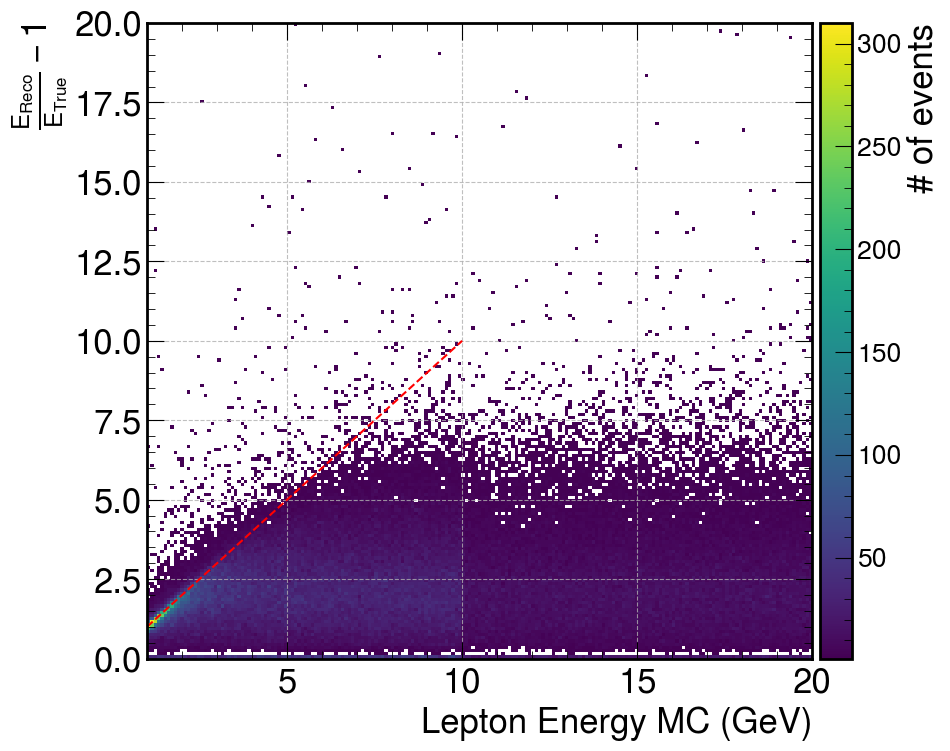

In [89]:

display_en_reco(
    dfres['E'],
    dfres['Echi2'],
    makefrac=False,
    binse = np.linspace(1,20,200),
    binsy = np.linspace(0,20,200),
    yscale='linear',
    xscale='linear',
    zscale='linear',
    figsize=(10,8)
)
plt.plot([1,10],[1,10], 'r--')
display_en_reco(
    dfres['E'],
    dfres['Ellhd'],
    makefrac=False,
    binse = np.linspace(1,20,200),
    binsy = np.linspace(0,20,200),
    yscale='linear',
    xscale='linear',
    zscale='linear',
    figsize=(10,8)
)
plt.plot([1,10],[1,10], 'r--')